# Introduction
The objective of this notebook is to create ARIMA timeseries forecasts using Python. This is based on: Jason Brownlee (2018) Deep Learning for Time Series Forecasting, Predict the Future with MLPs, CNNs and LSTMs in Python.
Key steps are:
1. Import the data and inspect
2. Import required libraries
3. Create required functions to:
    1. split the data into train and test 
    2. convert windows of weekly data to a continuous series
    3. calculate forecast accuracy
4. Reshape the data
5. Create forecast models
    1. Test for serial correlation
    2. Select lags and build model
6. Evaluate accuracy

# Import the data and inspect

In [1]:
# load the data
from pandas import read_csv
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [2]:
print(dataset.head())

            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313.0        

In [3]:
type(dataset)


pandas.core.frame.DataFrame

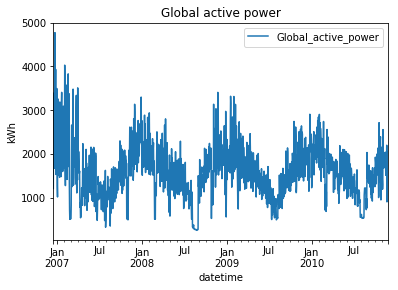

In [4]:
import matplotlib.pyplot as plt

plt.figure()
# gca stands for 'get current axis'
ax = plt.gca()
plt.ylabel('kWh')
plt.title('Global active power')

dataset.plot(kind='line', y='Global_active_power', ax=ax)

plt.show()

The chart above clearly shows a stationary timeseries with a seasonal cycle.

# Import required libraries

In [5]:
from numpy import split
from numpy import array

from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Create functions

##  Split the data into train and test

In [6]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test


## Convert windows of weekly data to a continuous series

In [7]:
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

## Calculate forecast accuracy

In [8]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# Reshape the data

In [9]:
train, test = split_dataset(dataset.values)
series = to_series(train)

# Create forecast models

## Test for serial correlation

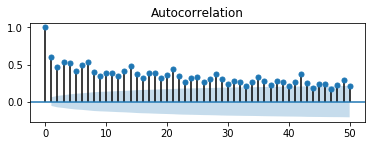

In [10]:
# create plots
pyplot.figure()
lags = 50

# plot the auto-correlation function
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)

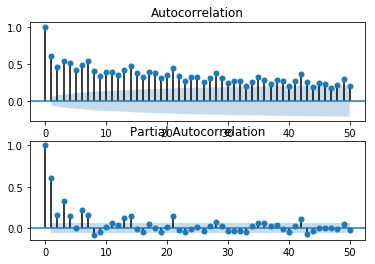

In [11]:
# plot the partial auto-correlation function
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)


The plots shown above indicate serial correlation for the first seven lags and then occasional serial correlation spikes at lags between 10 & 20 days and between 40 and 50 days. This suggests several seasonal cycles, namely: weekly, monthly and quarterly.

The Python library *statsmodels* has a decompose function that will split the time series into separate components: trend; seasonal; and noise (aka residual).

In [12]:
type(series)
print(series)

[ 3390.46   2203.826  1666.194 ...,  2211.892  1224.252  1309.268]


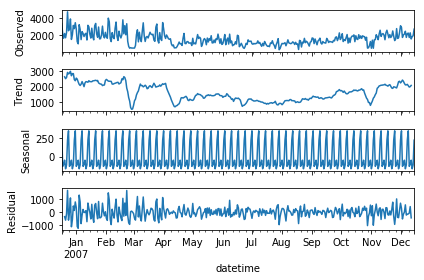

In [14]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dataset['Global_active_power'][1:365], model='additive')

result.plot()
pyplot.show()

The decomposition charts shown immediately above suggest a weekly seasonal cycle. There appears to be no other significant feature of the data except the serial correlation already noted above.

In [15]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [16]:
# arima forecast
def arima_forecast(history):
    from statsmodels.tsa.arima_model import ARIMA
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(7,0,0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

In [17]:
# arima forecast
def arima_forecast_1(history):
    from statsmodels.tsa.arima_model import ARIMA
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(0,0,0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

In [18]:
days = array(range(0,7))
print(days)

[0 1 2 3 4 5 6]


In [19]:
models = dict()
models['arima'] = arima_forecast
models['arima_1'] = arima_forecast_1
# evaluate each model
#days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = array(range(0,7))
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


arima: [381.616] 393.8, 398.9, 357.0, 377.2, 393.8, 306.0, 432.2
arima_1: [485.326] 475.9, 473.3, 458.8, 504.0, 472.4, 417.8, 579.7


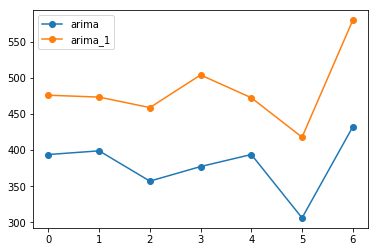

In [70]:
# show plot
pyplot.legend()
pyplot.show()

The results presented correspond to an auto-regressive model (7, 0, 0) against a naive model with no lags (0, 0, 0). The auto-regressive model clearly out-performs the naive model with a root mean squared error result (381.616) that is lower than the naive model (485.326).

End of notebook